# CH-5 Support Vector Machines and Kernel SVM 
- #### Codes related to the Support Vector Machines and Kernel SVM  chapter

 Step 1: Load and Preprocess Dataset

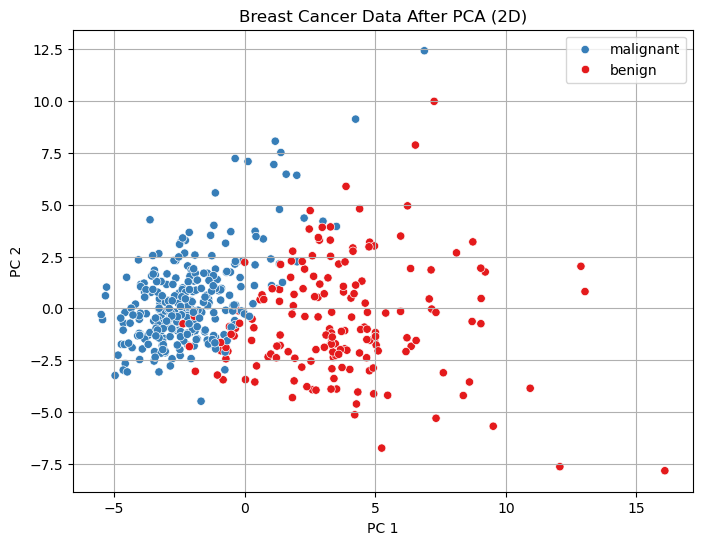

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = load_breast_cancer()
X = data.data
y = data.target
target_names = data.target_names

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA to 2 components for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Visualize 2D data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette="Set1")
plt.title("Breast Cancer Data After PCA (2D)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(labels=target_names)
plt.grid(True)
plt.show()


 Step 2: Train Linear SVM & Plot Decision Boundary

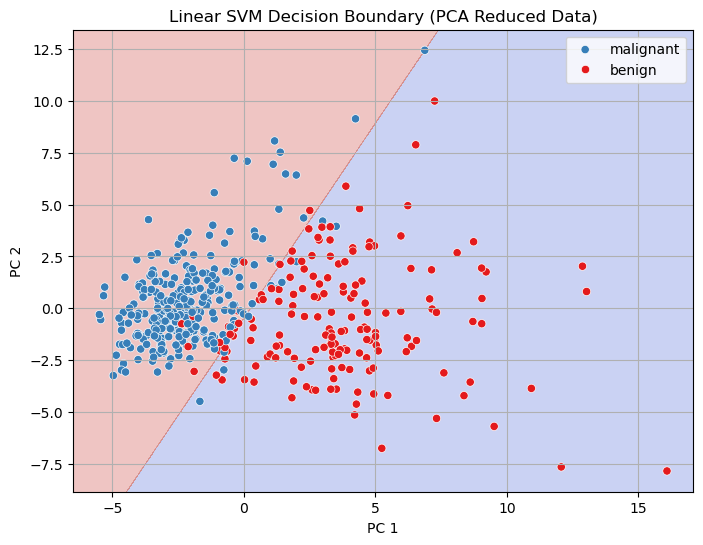

In [2]:
from sklearn.svm import SVC
import numpy as np

# Train Linear SVM on PCA-reduced data
linear_svm = SVC(kernel='linear')
linear_svm.fit(X_train_pca, y_train)

# Create meshgrid for plotting decision boundary
h = 0.01
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict over meshgrid
Z = linear_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette="Set1")
plt.title("Linear SVM Decision Boundary (PCA Reduced Data)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(labels=target_names)
plt.grid(True)
plt.show()


 Step 3: Train Kernel SVM (RBF) & Plot Decision Boundary

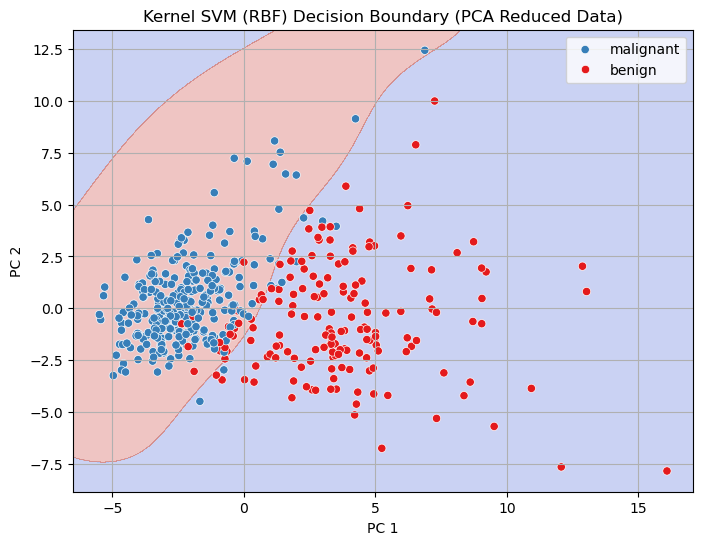

In [3]:
# Train RBF Kernel SVM on PCA-reduced data
rbf_svm = SVC(kernel='rbf', gamma='scale')  # gamma='scale' is default and usually good
rbf_svm.fit(X_train_pca, y_train)

# Predict over meshgrid
Z_rbf = rbf_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z_rbf = Z_rbf.reshape(xx.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_rbf, alpha=0.3, cmap='coolwarm')
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette="Set1")
plt.title("Kernel SVM (RBF) Decision Boundary (PCA Reduced Data)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(labels=target_names)
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predictions
y_pred_linear = linear_svm.predict(X_test_pca)
y_pred_rbf = rbf_svm.predict(X_test_pca)

# Accuracy
acc_linear = accuracy_score(y_test, y_pred_linear)
acc_rbf = accuracy_score(y_test, y_pred_rbf)

print("🔹 Accuracy Comparison:")
print(f"Linear SVM Accuracy: {acc_linear:.4f}")
print(f"Kernel SVM (RBF) Accuracy: {acc_rbf:.4f}\n")

# Confusion Matrices
print("🔹 Confusion Matrix (Linear SVM):")
print(confusion_matrix(y_test, y_pred_linear))

print("\n🔹 Confusion Matrix (Kernel SVM - RBF):")
print(confusion_matrix(y_test, y_pred_rbf))

🔹 Accuracy Comparison:
Linear SVM Accuracy: 0.9912
Kernel SVM (RBF) Accuracy: 0.9649

🔹 Confusion Matrix (Linear SVM):
[[42  1]
 [ 0 71]]

🔹 Confusion Matrix (Kernel SVM - RBF):
[[39  4]
 [ 0 71]]


1

Linear SVM Accuracy: 1.0


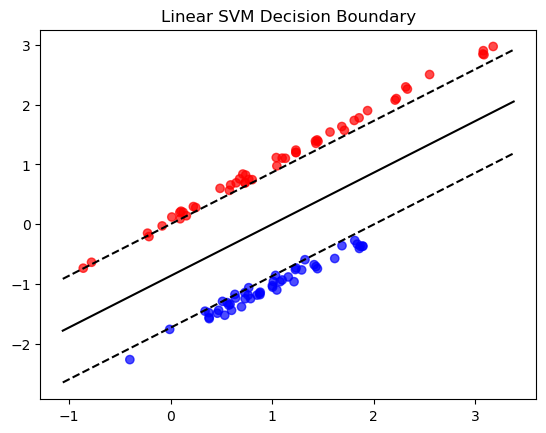

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from cvxopt import matrix, solvers

# 1. Generate a binary classification dataset
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0,
                           n_informative=2, n_clusters_per_class=1, random_state=42)
y = np.where(y == 0, -1, 1)  # convert labels to -1, 1

# 2. Define the kernel function (linear here)
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

# 3. Setup the QP problem
N, d = X.shape
K = np.dot(X, X.T)
P = matrix(np.outer(y, y) * K)
q = matrix(-np.ones(N))
G = matrix(np.vstack((-np.eye(N), np.eye(N))))
h = matrix(np.hstack((np.zeros(N), np.ones(N) * 1.0)))  # C = 1.0
A = matrix(y, (1, N), 'd')
b = matrix(0.0)

# 4. Solve QP problem
solvers.options['show_progress'] = False
solution = solvers.qp(P, q, G, h, A, b)
alphas = np.ravel(solution['x'])

# 5. Extract support vectors
support_indices = alphas > 1e-5
alpha_sv = alphas[support_indices]
X_sv = X[support_indices]
y_sv = y[support_indices]

# 6. Calculate w and b
w = np.sum(alpha_sv[:, None] * y_sv[:, None] * X_sv, axis=0)
b = np.mean(y_sv - np.dot(X_sv, w))

# 7. Predict function
def predict(X_input):
    return np.sign(np.dot(X_input, w) + b)

# 8. Accuracy
y_pred = predict(X)
accuracy = np.mean(y_pred == y)
print("Linear SVM Accuracy:", accuracy)

# 9. Plot decision boundary
def plot_svm(X, y, w, b):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1])
    yy = -(w[0] * xx + b) / w[1]

    margin = 1 / np.linalg.norm(w)
    yy_plus = yy + np.sqrt(1 + w[0]**2 / w[1]**2) * margin
    yy_minus = yy - np.sqrt(1 + w[0]**2 / w[1]**2) * margin

    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy_plus, 'k--')
    plt.plot(xx, yy_minus, 'k--')
    plt.title("Linear SVM Decision Boundary")
    plt.show()

plot_svm(X, y, w, b)


Linear SVM Accuracy: 1.0


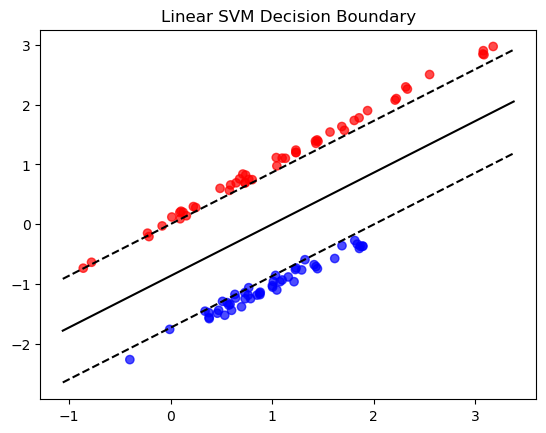

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from cvxopt import matrix, solvers

# 1. Generate a binary classification dataset
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0,
                           n_informative=2, n_clusters_per_class=1, random_state=42)
y = np.where(y == 0, -1, 1)  # convert labels to -1, 1

# 2. Define the kernel function (linear here)
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

# 3. Setup the QP problem
N, d = X.shape
K = np.dot(X, X.T)
P = matrix(np.outer(y, y) * K)
q = matrix(-np.ones(N))
G = matrix(np.vstack((-np.eye(N), np.eye(N))))
h = matrix(np.hstack((np.zeros(N), np.ones(N) * 1.0)))  # C = 1.0
A = matrix(y, (1, N), 'd')
b = matrix(0.0)

# 4. Solve QP problem
solvers.options['show_progress'] = False
solution = solvers.qp(P, q, G, h, A, b)
alphas = np.ravel(solution['x'])

# 5. Extract support vectors
support_indices = alphas > 1e-5
alpha_sv = alphas[support_indices]
X_sv = X[support_indices]
y_sv = y[support_indices]

# 6. Calculate w and b
w = np.sum(alpha_sv[:, None] * y_sv[:, None] * X_sv, axis=0)
b = np.mean(y_sv - np.dot(X_sv, w))

# 7. Predict function
def predict(X_input):
    return np.sign(np.dot(X_input, w) + b)

# 8. Accuracy
y_pred = predict(X)
accuracy = np.mean(y_pred == y)
print("Linear SVM Accuracy:", accuracy)

# 9. Plot decision boundary
def plot_svm(X, y, w, b):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1])
    yy = -(w[0] * xx + b) / w[1]

    margin = 1 / np.linalg.norm(w)
    yy_plus = yy + np.sqrt(1 + w[0]**2 / w[1]**2) * margin
    yy_minus = yy - np.sqrt(1 + w[0]**2 / w[1]**2) * margin

    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy_plus, 'k--')
    plt.plot(xx, yy_minus, 'k--')
    plt.title("Linear SVM Decision Boundary")
    plt.show()

plot_svm(X, y, w, b)


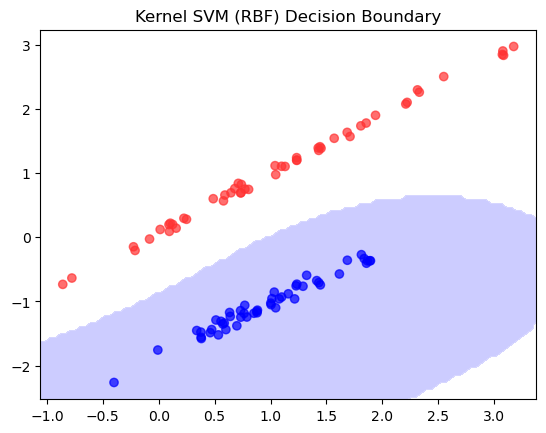

1.0

In [9]:
# Kernel SVM using Dual Formulation with RBF Kernel via cvxopt

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from cvxopt import matrix, solvers

# Generate dataset
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0,
                           n_informative=2, n_clusters_per_class=1, random_state=42)
y = np.where(y == 0, -1, 1)  # Convert to -1 and 1

# RBF kernel
def rbf_kernel(x1, x2, gamma=0.5):
    sq_dist = np.sum((x1[:, np.newaxis] - x2[np.newaxis, :]) ** 2, axis=2)
    return np.exp(-gamma * sq_dist)

# Compute Kernel matrix
K = rbf_kernel(X, X)

# Setup QP parameters
N = X.shape[0]
P = matrix(np.outer(y, y) * K)
q = matrix(-np.ones(N))
G = matrix(np.vstack([-np.eye(N), np.eye(N)]))
h = matrix(np.hstack([np.zeros(N), np.ones(N)]))  # C = 1
A = matrix(y, (1, N), 'd')
b = matrix(0.0)

# Solve QP
solvers.options['show_progress'] = False
solution = solvers.qp(P, q, G, h, A, b)
alphas = np.ravel(solution['x'])

# Support vectors
sv = alphas > 1e-5
X_sv = X[sv]
y_sv = y[sv]
alpha_sv = alphas[sv]

# Bias calculation
def compute_bias(X_sv, y_sv, alpha_sv, X, y, gamma=0.5):
    K_sv = rbf_kernel(X_sv, X_sv, gamma)
    return np.mean([y_sv[i] - np.sum(alpha_sv * y_sv * K_sv[i]) for i in range(len(X_sv))])

b_rbf = compute_bias(X_sv, y_sv, alpha_sv, X, y)

# Prediction function
def predict_rbf(X_input, X_sv, y_sv, alpha_sv, b, gamma=0.5):
    K_input = rbf_kernel(X_input, X_sv, gamma)
    return np.sign(np.dot(K_input, alpha_sv * y_sv) + b)

# Predictions and accuracy
y_pred_rbf = predict_rbf(X, X_sv, y_sv, alpha_sv, b_rbf)
accuracy_rbf = accuracy_score(y, y_pred_rbf)

# Decision boundary plot
def plot_ksvm(X, y, X_sv, y_sv, alpha_sv, b, gamma=0.5):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx, yy = np.meshgrid(np.linspace(*xlim, 100), np.linspace(*ylim, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = predict_rbf(grid, X_sv, y_sv, alpha_sv, b, gamma).reshape(xx.shape)

    plt.contourf(xx, yy, zz, levels=[-1, 0, 1], alpha=0.2, colors=['blue', 'white', 'red'])
    plt.title("Kernel SVM (RBF) Decision Boundary")
    plt.show()

plot_ksvm(X, y, X_sv, y_sv, alpha_sv, b_rbf)

accuracy_rbf


## 🧠 Kernel SVM vs Linear SVM on make_moons and make_circles

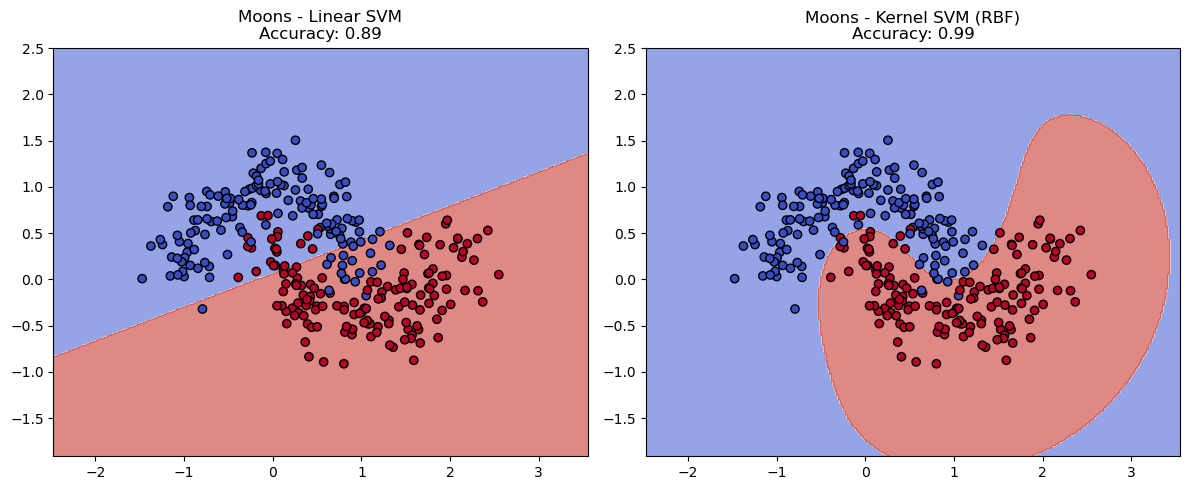

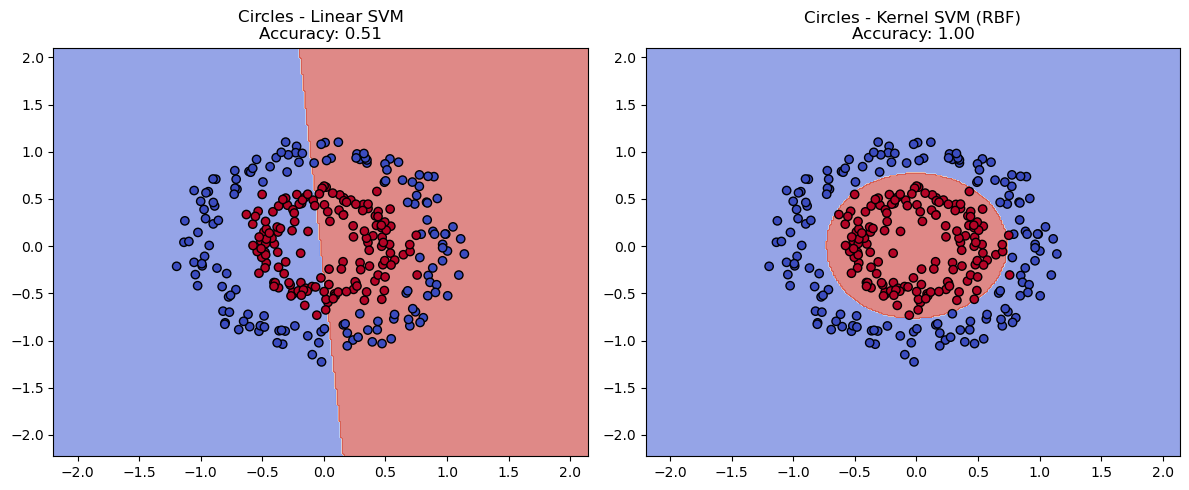

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from cvxopt import matrix, solvers

# RBF Kernel
def rbf_kernel(x1, x2, gamma=1.0):
    if x1.ndim == 1 and x2.ndim == 1:
        return np.exp(-np.linalg.norm(x1 - x2) ** 2 * gamma)
    elif (x1.ndim > 1 and x2.ndim == 1) or (x1.ndim == 1 and x2.ndim > 1):
        return np.exp(-np.linalg.norm(x1 - x2, axis=1) ** 2 * gamma)
    else:
        return np.exp(-np.linalg.norm(x1[:, np.newaxis] - x2[np.newaxis, :], axis=2) ** 2 * gamma)

# SVM class
class SVM:
    def __init__(self, kernel=rbf_kernel, C=1.0, gamma=1.0):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma

    def fit(self, X, y):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i], X[j], self.gamma) if self.kernel != 'linear' else np.dot(X[i], X[j])

        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones(n_samples))
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), self.C * np.ones(n_samples))))
        A = matrix(y.astype('double'), (1, n_samples))
        b = matrix(0.0)

        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.ravel(sol['x'])

        sv = alphas > 1e-5
        self.alphas = alphas[sv]
        self.sv_X = X[sv]
        self.sv_y = y[sv]

        if self.kernel == 'linear':
            self.w = np.sum(self.alphas[:, np.newaxis] * self.sv_y[:, np.newaxis] * self.sv_X, axis=0)

        self.b = np.mean([
            y_k - np.sum(self.alphas * self.sv_y * 
                         np.array([self.kernel(x_k, x_i, self.gamma) if self.kernel != 'linear' else np.dot(x_k, x_i)
                                   for x_i in self.sv_X]))
            for x_k, y_k in zip(self.sv_X, self.sv_y)
        ])

    def project(self, X):
        if self.kernel == 'linear':
            return np.dot(X, self.w) + self.b
        else:
            return np.array([
                np.sum(self.alphas * self.sv_y * np.array(
                    [self.kernel(x, sv_x, self.gamma) for sv_x in self.sv_X])) + self.b for x in X
            ])

    def predict(self, X):
        return np.sign(self.project(X))

# Compare function with combined plot
def compare_and_plot(X, y, title):
    y = np.where(y == 0, -1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    svm_linear = SVM(kernel='linear', C=1.0)
    svm_linear.fit(X_train, y_train)
    y_pred_linear = svm_linear.predict(X_test)
    acc_linear = accuracy_score(y_test, y_pred_linear)

    svm_rbf = SVM(kernel=rbf_kernel, C=1.0, gamma=1.0)
    svm_rbf.fit(X_train, y_train)
    y_pred_rbf = svm_rbf.predict(X_test)
    acc_rbf = accuracy_score(y_test, y_pred_rbf)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    XX, YY = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    xy = np.c_[XX.ravel(), YY.ravel()]

    Z_linear = svm_linear.predict(xy).reshape(XX.shape)
    Z_rbf = svm_rbf.predict(xy).reshape(XX.shape)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].contourf(XX, YY, Z_linear, alpha=0.6, cmap=plt.cm.coolwarm)
    axs[0].scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    axs[0].set_title(f"{title} - Linear SVM\nAccuracy: {acc_linear:.2f}")

    axs[1].contourf(XX, YY, Z_rbf, alpha=0.6, cmap=plt.cm.coolwarm)
    axs[1].scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    axs[1].set_title(f"{title} - Kernel SVM (RBF)\nAccuracy: {acc_rbf:.2f}")

    plt.tight_layout()
    plt.show()

# Generate datasets
X_moons, y_moons = make_moons(n_samples=300, noise=0.2, random_state=42)
X_circles, y_circles = make_circles(n_samples=300, noise=0.1, factor=0.5, random_state=42)

# Plot for moons and circles
compare_and_plot(X_moons, y_moons, "Moons")
compare_and_plot(X_circles, y_circles, "Circles")


## Lets try on Spiral Data 

Linear SVM Accuracy on Spiral: 0.60


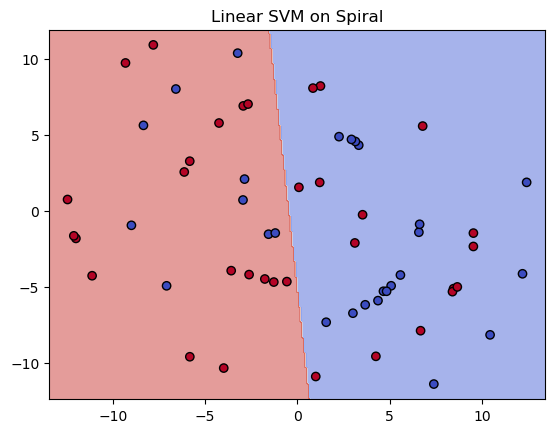

Kernel SVM (RBF) Accuracy on Spiral: 0.97


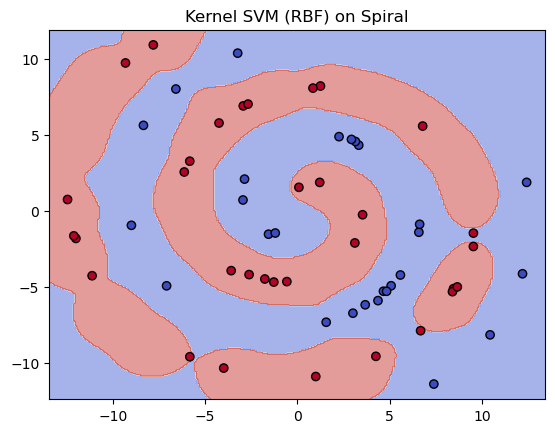

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from cvxopt import matrix, solvers

# Generate Spiral Data
def generate_spiral(n_points, noise=0.5):
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    X1 = np.hstack((d1x,d1y))
    
    d2x = np.cos(n)*n + np.random.rand(n_points,1) * noise
    d2y = -np.sin(n)*n + np.random.rand(n_points,1) * noise
    X2 = np.hstack((d2x,d2y))

    X = np.vstack((X1, X2))
    y = np.hstack((np.ones(n_points), -1*np.ones(n_points)))
    return X, y

# RBF kernel function
def rbf_kernel(x1, x2, gamma=1.0):
    if x1.ndim == 1 and x2.ndim == 1:
        return np.exp(-np.linalg.norm(x1 - x2) ** 2 * gamma)
    elif (x1.ndim > 1 and x2.ndim == 1) or (x1.ndim == 1 and x2.ndim > 1):
        return np.exp(-np.linalg.norm(x1 - x2, axis=1) ** 2 * gamma)
    else:
        return np.exp(-np.linalg.norm(x1[:, np.newaxis] - x2[np.newaxis, :], axis=2) ** 2 * gamma)

# SVM class as before
class SVM:
    def __init__(self, kernel=rbf_kernel, C=1.0, gamma=1.0):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma

    def fit(self, X, y):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j], self.gamma) if self.kernel != 'linear' else np.dot(X[i], X[j])
        
        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones(n_samples))
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), self.C * np.ones(n_samples))))
        A = matrix(y.astype('double'), (1, n_samples))
        b = matrix(0.0)

        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.ravel(sol['x'])

        sv = alphas > 1e-5
        self.alphas = alphas[sv]
        self.sv_X = X[sv]
        self.sv_y = y[sv]

        if self.kernel == 'linear':
            self.w = np.sum(self.alphas[:, np.newaxis] * self.sv_y[:, np.newaxis] * self.sv_X, axis=0)
        
        self.b = np.mean([
            y_k - np.sum(self.alphas * self.sv_y * 
                         np.array([self.kernel(x_k, x_i, self.gamma) if self.kernel != 'linear' else np.dot(x_k, x_i)
                                   for x_i in self.sv_X]))
            for x_k, y_k in zip(self.sv_X, self.sv_y)
        ])

    def project(self, X):
        if self.kernel == 'linear':
            return np.dot(X, self.w) + self.b
        else:
            return np.array([
                np.sum(self.alphas * self.sv_y * np.array(
                    [self.kernel(x, sv_x, self.gamma) for sv_x in self.sv_X])) + self.b for x in X
            ])

    def predict(self, X):
        return np.sign(self.project(X))

# Visualization
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
    y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
    XX, YY = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    xy = np.c_[XX.ravel(), YY.ravel()]
    Z = model.predict(xy).reshape(XX.shape)

    plt.contourf(XX, YY, Z, alpha=0.5, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(title)
    plt.show()

# Run on Spiral
X_spiral, y_spiral = generate_spiral(100, noise=0.3)
X_train, X_test, y_train, y_test = train_test_split(X_spiral, y_spiral, test_size=0.3)

# Linear SVM
svm_linear = SVM(kernel='linear', C=1.0)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)
acc_linear = accuracy_score(y_test, y_pred_linear)
print(f"Linear SVM Accuracy on Spiral: {acc_linear:.2f}")
plot_decision_boundary(svm_linear, X_test, y_test, "Linear SVM on Spiral")

# RBF Kernel SVM
svm_rbf = SVM(kernel=rbf_kernel, C=1.0, gamma=0.5)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)
acc_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"Kernel SVM (RBF) Accuracy on Spiral: {acc_rbf:.2f}")
plot_decision_boundary(svm_rbf, X_test, y_test, "Kernel SVM (RBF) on Spiral")


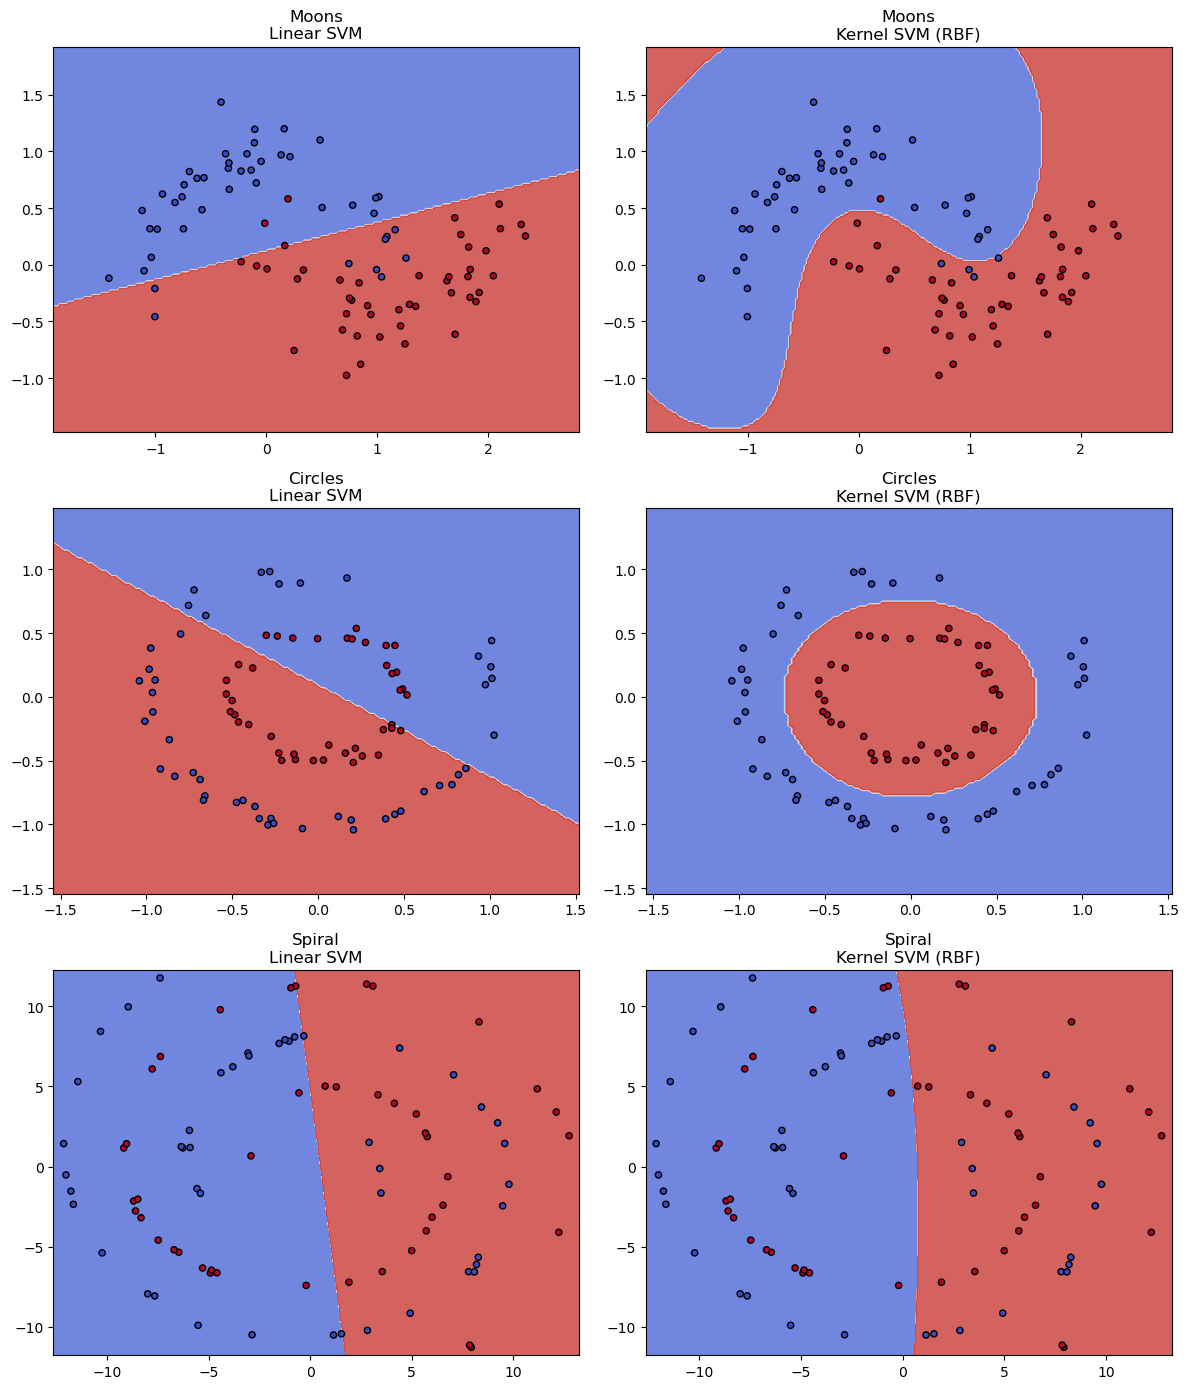

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# RBF Kernel
def rbf_kernel(x, y, gamma=1.0):
    if x.ndim == 1 and y.ndim == 1:
        return np.exp(-gamma * np.linalg.norm(x - y) ** 2)
    elif x.ndim == 1:
        return np.exp(-gamma * np.linalg.norm(x - y, axis=1) ** 2)
    elif y.ndim == 1:
        return np.exp(-gamma * np.linalg.norm(x - y, axis=1) ** 2)
    else:
        return np.exp(-gamma * np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], axis=2) ** 2)

# Custom SVM class
class SVM:
    def __init__(self, kernel='linear', C=1.0, gamma=1.0):
        self.C = C
        self.gamma = gamma
        if kernel == 'linear':
            self.kernel = self.linear_kernel
        elif callable(kernel):
            self.kernel = lambda x, y: kernel(x, y, gamma)
        else:
            raise ValueError("Invalid kernel")

    def linear_kernel(self, x, y):
        return np.dot(x, y.T)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        K = self.kernel(X, X)
        P = np.outer(y, y) * K
        q = -np.ones(n_samples)
        A = y.astype(float)
        b = 0.0
        G = np.vstack([-np.eye(n_samples), np.eye(n_samples)])
        h = np.hstack([np.zeros(n_samples), np.ones(n_samples) * self.C])

        from cvxopt import matrix, solvers
        solvers.options['show_progress'] = False
        P = matrix(P)
        q = matrix(q)
        G = matrix(G)
        h = matrix(h)
        A = matrix(A, (1, n_samples))
        b = matrix(b)
        solution = solvers.qp(P, q, G, h, A, b)

        alphas = np.ravel(solution['x'])
        sv = alphas > 1e-5
        self.alphas = alphas[sv]
        self.sv_X = X[sv]
        self.sv_y = y[sv]

        self.b = np.mean([y_k - np.sum(self.alphas * self.sv_y * self.kernel(self.sv_X, x_k))
                          for (x_k, y_k) in zip(self.sv_X, self.sv_y)])

    def project(self, X):
        return np.array([np.sum(self.alphas * self.sv_y * self.kernel(self.sv_X, x)) + self.b for x in X])

    def predict(self, X):
        return np.sign(self.project(X))

# Plotting utility
def plot_comparison(ax, svm_linear, svm_rbf, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z_linear = svm_linear.predict(grid).reshape(xx.shape)
    Z_rbf = svm_rbf.predict(grid).reshape(xx.shape)

    ax[0].contourf(xx, yy, Z_linear, cmap=plt.cm.coolwarm, alpha=0.8)
    ax[0].scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax[0].set_title(f"{title}\nLinear SVM")

    ax[1].contourf(xx, yy, Z_rbf, cmap=plt.cm.coolwarm, alpha=0.8)
    ax[1].scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax[1].set_title(f"{title}\nKernel SVM (RBF)")

# Dataset generators
def generate_spiral(n_points, noise=0.5):
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    X1 = np.hstack((d1x,d1y))
    y1 = np.zeros(n_points)

    d2x = np.cos(n)*n + np.random.rand(n_points,1) * noise
    d2y = -np.sin(n)*n + np.random.rand(n_points,1) * noise
    X2 = np.hstack((d2x,d2y))
    y2 = np.ones(n_points)

    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))
    y = 2*y - 1  # Convert to -1, 1
    return X, y

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 14))

# Dataset 1: Moons
X, y = make_moons(n_samples=300, noise=0.2)
y = 2*y - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
svm_lin = SVM(kernel='linear', C=1.0)
svm_rbf = SVM(kernel=rbf_kernel, C=1.0, gamma=1.0)
svm_lin.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)
plot_comparison(axes[0], svm_lin, svm_rbf, X_test, y_test, "Moons")

# Dataset 2: Circles
X, y = make_circles(n_samples=300, noise=0.05, factor=0.5)
y = 2*y - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
svm_lin = SVM(kernel='linear', C=1.0)
svm_rbf = SVM(kernel=rbf_kernel, C=1.0, gamma=1.0)
svm_lin.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)
plot_comparison(axes[1], svm_lin, svm_rbf, X_test, y_test, "Circles")

# Dataset 3: Spiral
X, y = generate_spiral(150)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
svm_lin = SVM(kernel='linear', C=1.0)
svm_rbf = SVM(kernel=rbf_kernel, C=1.0, gamma=1e-3)
svm_lin.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)
plot_comparison(axes[2], svm_lin, svm_rbf, X_test, y_test, "Spiral")

plt.tight_layout()
plt.show()

